## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import time
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from logger import TBLogger

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [3]:
from matplotlib.image import imread
from extract_patches import *

In [4]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=64)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [5]:
len(images)

25008

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

In [7]:
def show_img_grid(images, grid_shape = (4, 4)):
    fig, img_plots = plt.subplots(*grid_shape, figsize=(8, 8), gridspec_kw = {'wspace':0.05, 'hspace':0.05})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_shape[0]):
        for j in range(0, grid_shape[1]):
            img_plt = img_plots[i, j]

            img = images[i * grid_shape[1] + j]
            img_plt.imshow(np.squeeze(img), cmap="afmhot")
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    
    fig.savefig('imgs_test/grid.png')



In [25]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

In [26]:
tensor_images.size(), tensor_images.mean()

(torch.Size([25008, 1, 64, 64]), tensor(114.2698))

In [27]:
tensor_images = tensor_images / 124.5872

In [10]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
TINY = 1e-15

patch_size = 64 # image size = 64 x 64 = 4096
batch_size = 512
emb_size = 2048
conv_emb_size = 128 * 4 * 4

## Load saved Model

In [12]:
# just a namespace
class ConvAAE():
    class Encoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Encoder, self).__init__()
            
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
            
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
                
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
                
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2, stride=2),
            
                Flatten()
            )

        def forward(self, input_data):
            # generate embeddings for our images
            embeddings = self.encoder(input_data)

            return embeddings

        
    class Decoder(nn.Module):
        def __init__(self, image_channels=1):
            super(ConvAAE.Decoder, self).__init__()
            
            self.decoder = nn.Sequential(
                Unflatten(C=128, H=4, W=4),

                # upsampling + conv
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, 3, 1, 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64, 64, 3, 1, 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),

                # upsampling + conv
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
                
                nn.Conv2d(32, 32, 3, 1, 1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),

                # upsampling + conv
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.Conv2d(16, 16, 3, 1, 1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                # upsampling + conv
                nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                
                nn.Conv2d(16, 16, 3, 1, 1),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),

                nn.Conv2d(16, image_channels, 3, 1, 1),
            )


        def forward(self, input_embeddings):
            data = self.decoder(input_embeddings)
            
            return data

#     class Discriminator(nn.Module):
#         def __init__(self, image_channels=1):
#             super(ConvAAE.Discriminator, self).__init__()

#             self.discriminator = nn.Sequential(
#                 nn.Linear(emb_size, 10),
#                 nn.LeakyReLU(),
                
#                 nn.Linear(10, 10),
#                 nn.LeakyReLU(),

#                 # linear layer with 1 element
#                 nn.Linear(10, 1),

#                 nn.Sigmoid()
#             )

#         def forward(self, input_embeddings):
#             # process embeddings and guess if it's real or fake
#             discriminator_output = self.discriminator(input_embeddings)

#             return discriminator_output

print('    ENCODER')
summary(ConvAAE.Encoder().to(device), (1, patch_size, patch_size))

print('\n\n    DECODER')
summary(ConvAAE.Decoder().to(device), (1, emb_size))

# print('\n\n    DISCRIMINATOR')
# summary(ConvAAE.Discriminator().to(device), (1, emb_size))

    ENCODER
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         LeakyReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           2,320
       BatchNorm2d-5           [-1, 16, 64, 64]              32
         LeakyReLU-6           [-1, 16, 64, 64]               0
         MaxPool2d-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           4,640
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        LeakyReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,248
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        LeakyReLU-13           [-1, 32, 32, 32]               0
        MaxPool2d-14       

In [13]:
learning_rate = 1e-5


def reset_model():
    global encoder_net, decoder_net, discrim_net

    # creating sub-models
    encoder_net = ConvAAE.Encoder().to(device)
    decoder_net = ConvAAE.Decoder().to(device)
#     discrim_net = ConvAAE.Discriminator().to(device)

reset_model()

In [14]:
models_folder = './logs/continue big net. smaller LR 09-33-53/models/'
target_epoch = 10

reset_model()

encoder_net.load_state_dict(torch.load(models_folder + f'encoder_net_e_{target_epoch}.pth'))
decoder_net.load_state_dict(torch.load(models_folder + f'decoder_net_e_{target_epoch}.pth'))
# discrim_net.load_state_dict(torch.load(models_folder + f'discrim_net_e_{target_epoch}.pth'))

_ = encoder_net.eval(), decoder_net.eval() #, discrim_net.eval()

### Test

In [15]:
def predict(images):
    test_data = images.to(device)

    # forward
    embeddings = encoder_net(test_data)
    test_output = decoder_net(embeddings)
    
    return embeddings.data.cpu().numpy(), test_output.data.cpu().numpy()


def predict_and_print(images):
    embeddings, predicted_images = predict(images)

    show_img_grid(predicted_images)


In [16]:
def show_img_grid(images, grid_shape = (4, 4)):
    fig, img_plots = plt.subplots(*grid_shape, figsize=(8, 8), gridspec_kw = {'wspace':0.01, 'hspace':0.01})

    fig.patch.set_facecolor('black')

    for i in range(0, grid_shape[0]):
        for j in range(0, grid_shape[1]):
            img_plt = img_plots[i, j]

            img = images[i * grid_shape[1] + j]
            img_plt.imshow(np.squeeze(img))
            img_plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    

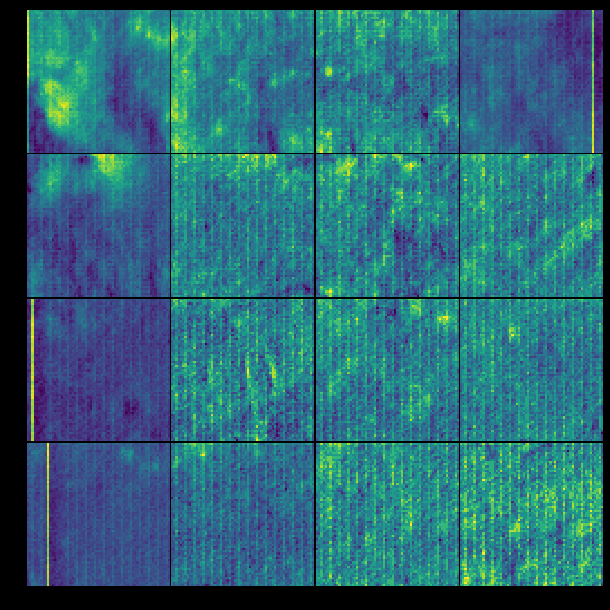

In [17]:
show_img_grid(tensor_images[0:16])

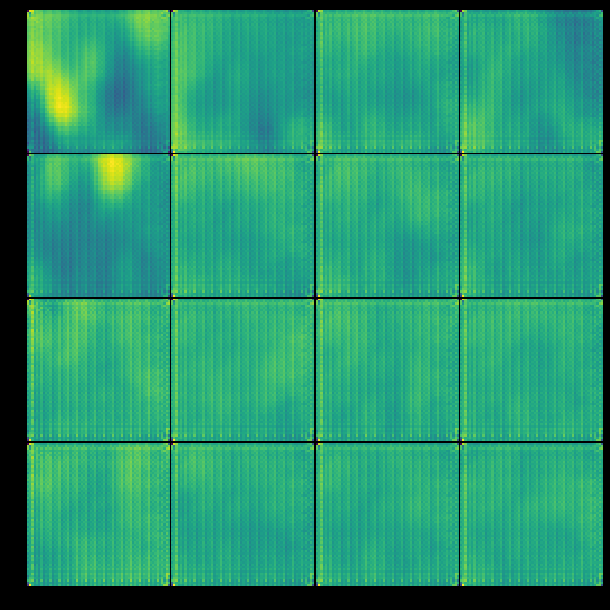

In [28]:
predict_and_print(tensor_images[0:16])

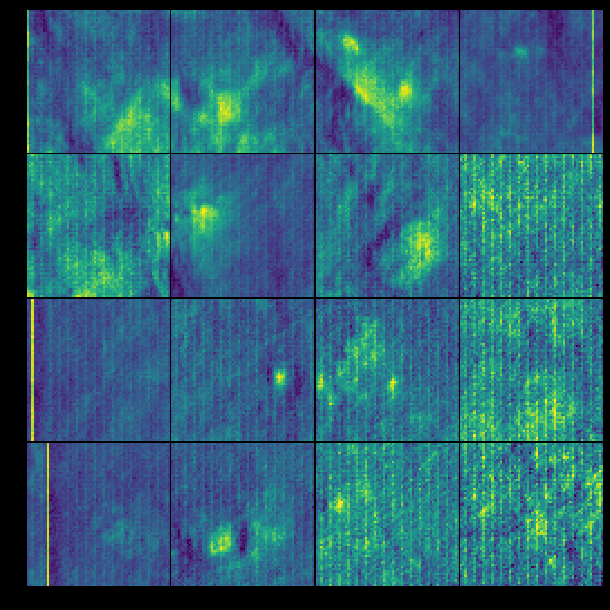

In [18]:
show_img_grid(tensor_images[16:32])

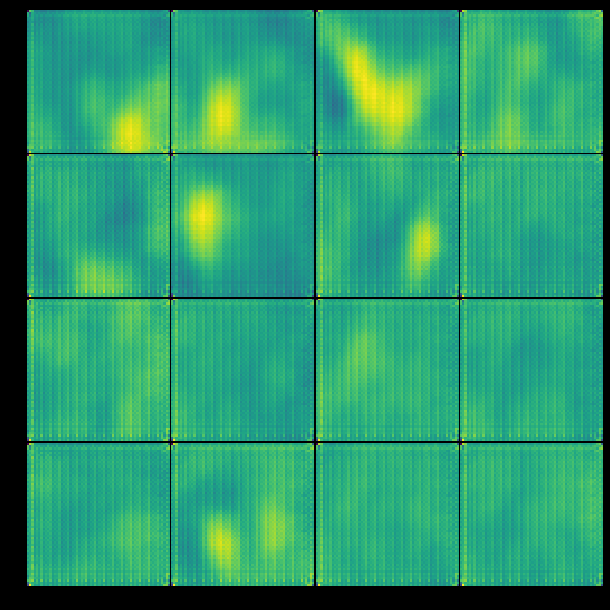

In [29]:
predict_and_print(tensor_images[16:32])

In [55]:
embeddings, _ = predict(tensor_images[0:1])
np.squeeze(embeddings).shape

(1500,)

In [56]:
import seaborn as sns

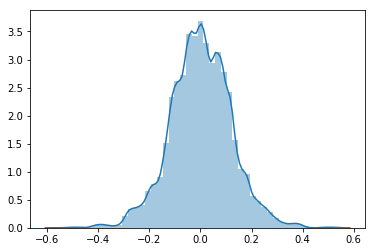

In [57]:
embeddings, _ = predict(tensor_images[0:200])

sns.distplot(np.concatenate(embeddings))

In [24]:
from itertools import cycle
from os import listdir
from os.path import isfile, join

In [25]:
data_path = './data'
files_per_epoch = 5

# get all red files
red_img_files = [f for f in listdir(data_path)
                 if isfile(join(data_path, f)) and 'RED' in f]

In [48]:
for img_name in red_img_files:
    sample_img = np.asarray(extract_img(f'data/{img_name}'))

    if sample_img.shape[0] == 1000:
        print('skipping corrupted image')
        continue
    
    sample_img = sample_img[..., np.newaxis]

    patches = extract_patches(sample_img, patch_size=256)
    
    images, ids = get_patches_ids(patches, img_name)
    
    plt.imsave('./imgs_test/' + ids[0] + '.png', np.squeeze(images[0]))
    
    print(sample_img.shape)

(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(75000, 512, 1)
(100000, 1024, 1)
(100000, 1024, 1)
(80000, 1024, 1)
(60000, 1024, 1)
(60000, 1024, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(25000, 512, 1)
(50000, 1024, 1)
(30000, 512, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(60000, 1024, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(50000, 256, 1)
(50000, 256, 1)
(50000, 1024, 1)
(60000, 1024, 1)
(40000, 512, 1)
(40000, 512, 1)
(40000, 512, 1)
(30000, 512, 1)
(30000, 512, 1)
(40000, 512, 1)
(40000, 512, 1)
(45000, 1024, 1)
(40000, 512, 1)
(40000, 512, 1)
(40000, 1024, 1)
(50000, 1024, 1)
(45000, 512, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(70000, 1024, 1)
(35000, 512, 1)
(35000, 512, 1)
(40000, 1024, 1)
(40000, 1024, 1)
(45000, 1024, 1)
(45000, 1024, 1)
(35000, 512, 1)
(35000, 512, 1)
(60000, 1024, 1)
(30000, 256, 1)
(40000, 1024, 1)
(70000, 1024, 1)
(100000, 1024, 

In [97]:
dummy_data =np.arange(60)
dummy_data = dummy_data[..., np.newaxis]
dummy_data.shape

(60, 1)

In [100]:
dummy_tensor = torch.from_numpy(dummy_data).float()
dataset = torch.utils.data.TensorDataset(dummy_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=20)

In [101]:
# loop over mini-batches sampled from patches in current dataset
for i, (data,) in enumerate(loader):

    print(data)

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.]])
tensor([[20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.],
        [32.],
        [33.],
        [34.],
        [35.],
        [36.],
        [37.],
        [38.],
        [39.]])
tensor([[40.],
        [41.],
        [42.],
        [43.],
        [44.],
        [45.],
        [46.],
        [47.],
        [48.],
        [49.],
        [50.],
        [51.],
        [52.],
        [53.],
        [54.],
        [55.],
        [56.],
        [57.],
        [58.],
        [59.]])
